<a href="https://colab.research.google.com/github/Rahul231100/ADM_project/blob/main/FAKE_REVIEW_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# PART 1: Import Libraries & Load Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For text analysis and machine learning
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load your dataset (make sure it's in the same folder or provide full path)
df = pd.read_csv("fake_reviews_dataset.csv")

# Handle any missing values
df.fillna('', inplace=True)

# Preview the first few rows of the data
print("✅ Sample Data:")
print(df.head())


✅ Sample Data:
                                     Review Text  Rating    Verified  \
0           Okay product, but delivery was late.       3  Unverified   
1             Received a damaged item. Very bad.       3    Verified   
2                Good quality and fast shipping.       3    Verified   
3  Amazing customer service and product quality.       1    Verified   
4             Received a damaged item. Very bad.       3  Unverified   

  Review Time         User Name                       User Email  
0  2025-03-08    Regina Hensley                jkeller@yahoo.com  
1  2023-05-02  Rebecca Bruce MD        thorntonphillip@gmail.com  
2  2023-11-15        Edwin Hess                 juan14@yahoo.com  
3  2025-02-09    Teresa Sanders                  tlopez@cruz.com  
4  2024-08-09    Thomas Pearson  anthonyfreeman@green-duarte.com  


In [ ]:
# PART 2: Feature Engineering

from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder

# Create new features from review text and user details
df['review_length'] = df['Review Text'].apply(len)
df['sentiment'] = df['Review Text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['is_duplicate'] = df.duplicated(['Review Text']).astype(int)
df['email_domain'] = df['User Email'].apply(lambda x: x.split('@')[-1])
df['word_count'] = df['Review Text'].apply(lambda x: len(x.split()))
df['uppercase_words'] = df['Review Text'].apply(lambda x: sum(1 for w in x.split() if w.isupper()))

# Encode categorical features
df['email_domain_encoded'] = LabelEncoder().fit_transform(df['email_domain'])
df['verified_encoded'] = LabelEncoder().fit_transform(df['Verified'])

# View the new features
print(df[['Review Text', 'review_length', 'sentiment', 'is_duplicate',
          'email_domain', 'word_count', 'uppercase_words',
          'email_domain_encoded', 'verified_encoded']].head())


                                     Review Text  review_length  sentiment  \
0           Okay product, but delivery was late.             36       0.10   
1             Received a damaged item. Very bad.             34      -0.91   
2                Good quality and fast shipping.             31       0.45   
3  Amazing customer service and product quality.             45       0.60   
4             Received a damaged item. Very bad.             34      -0.91   

   is_duplicate      email_domain  word_count  uppercase_words  \
0             0         yahoo.com           6                0   
1             0         gmail.com           6                0   
2             0         yahoo.com           5                0   
3             0          cruz.com           6                0   
4             1  green-duarte.com           6                0   

   email_domain_encoded  verified_encoded  
0                   238                 0  
1                    70                 1  
2 

In [ ]:
# PART 3: Label Fake Reviews using simple rules

# Rule-based labeling for fake reviews
df['is_fake'] = 0  # Default: not fake

# Mark as fake if review is duplicate, from unverified user, or has extreme sentiment
df.loc[(df['is_duplicate'] == 1) |
       (df['verified_encoded'] == 0) |
       (df['sentiment'] > 0.9) |
       (df['sentiment'] < -0.9), 'is_fake'] = 1

# Show some labeled examples
print(df[['Review Text', 'is_duplicate', 'verified_encoded', 'sentiment', 'is_fake']].head(10))


                                     Review Text  is_duplicate  \
0           Okay product, but delivery was late.             0   
1             Received a damaged item. Very bad.             0   
2                Good quality and fast shipping.             0   
3  Amazing customer service and product quality.             0   
4             Received a damaged item. Very bad.             1   
5           Not as described, very disappointed.             0   
6           Okay product, but delivery was late.             1   
7      Terrible experience, would not recommend.             0   
8           Okay product, but delivery was late.             1   
9            It’s just average, nothing special.             0   

   verified_encoded  sentiment  is_fake  
0                 0   0.100000        1  
1                 1  -0.910000        1  
2                 1   0.450000        0  
3                 1   0.600000        0  
4                 0  -0.910000        1  
5                 0  

In [ ]:
# PART 4: Vectorize Text and Prepare Features

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Vectorize review text using TF-IDF
tfidf = TfidfVectorizer(max_features=300)
text_features = tfidf.fit_transform(df['Review Text']).toarray()

# Combine text features with selected numeric features
other_features = df[['review_length', 'sentiment', 'is_duplicate',
                     'verified_encoded', 'email_domain_encoded',
                     'word_count', 'uppercase_words']].values

# Final feature set
X = np.hstack((text_features, other_features))
y = df['is_fake']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X (features):", X.shape)
print("Shape of y (labels):", y.shape)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Shape of X (features): (500, 52)
Shape of y (labels): (500,)
Training set size: (400, 52)
Test set size: (100, 52)


In [ ]:
# PART 5: Train Model and Evaluate

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Accuracy: 0.97

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.97      1.00      0.98        97

    accuracy                           0.97       100
   macro avg       0.48      0.50      0.49       100
weighted avg       0.94      0.97      0.96       100



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Calculate and print accuracy in percentage
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy: {:.2f}%".format(accuracy * 100))


Model Accuracy: 97.00%


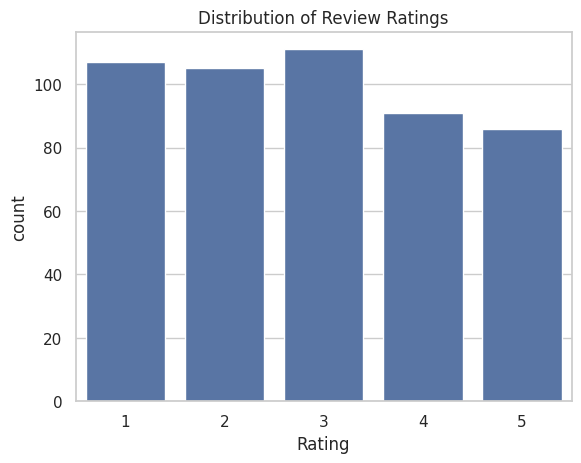

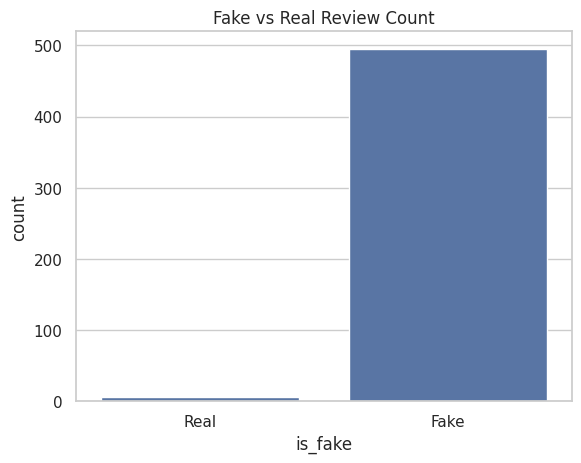

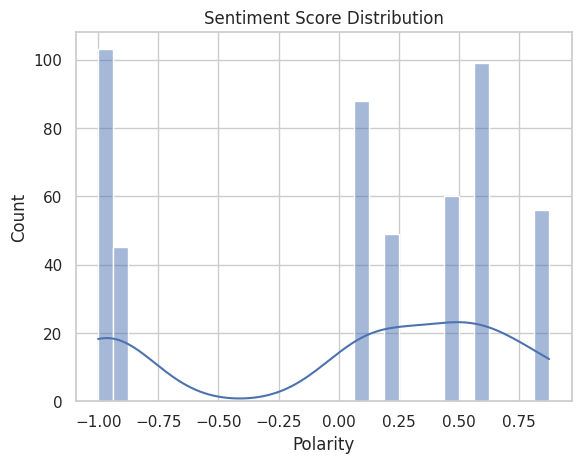

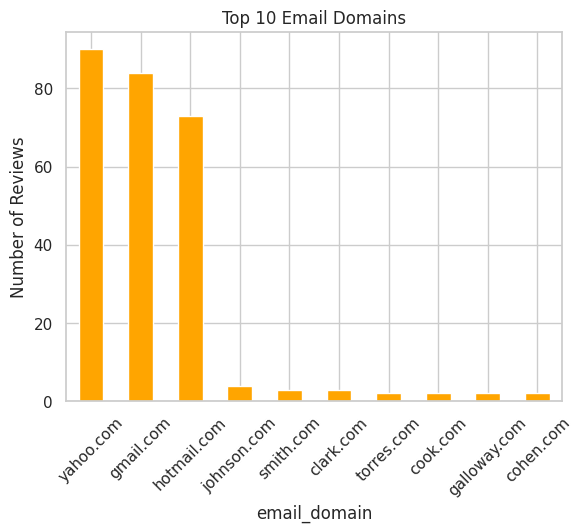

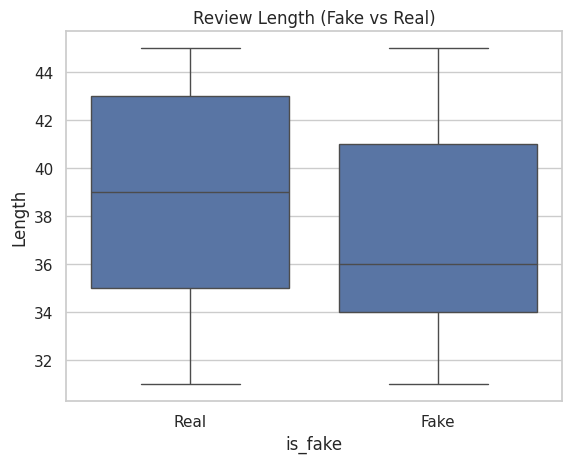

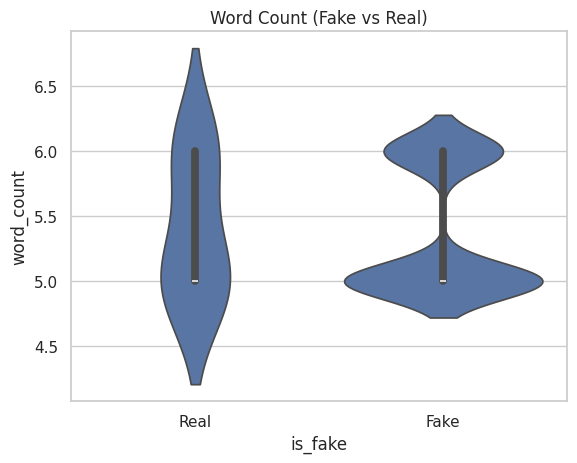

In [ ]:
sns.set(style="whitegrid")

# 1. Rating Distribution
sns.countplot(x='Rating', data=df)
plt.title("Distribution of Review Ratings")
plt.show()

# 2. Fake vs Real Review Count
sns.countplot(x='is_fake', data=df)
plt.title("Fake vs Real Review Count")
plt.xticks([0, 1], ['Real', 'Fake'])
plt.show()

# 3. Sentiment Distribution
sns.histplot(df['sentiment'], bins=30, kde=True)
plt.title("Sentiment Score Distribution")
plt.xlabel("Polarity")
plt.show()

# 4. Top Email Domains
top_domains = df['email_domain'].value_counts().head(10)
top_domains.plot(kind='bar', color='orange')
plt.title("Top 10 Email Domains")
plt.xticks(rotation=45)
plt.ylabel("Number of Reviews")
plt.show()

# 5. Review Length Boxplot
sns.boxplot(x='is_fake', y='review_length', data=df)
plt.title("Review Length (Fake vs Real)")
plt.xticks([0, 1], ['Real', 'Fake'])
plt.ylabel("Length")
plt.show()

# 6. Word Count Violin Plot
sns.violinplot(x='is_fake', y='word_count', data=df)
plt.title("Word Count (Fake vs Real)")
plt.xticks([0, 1], ['Real', 'Fake'])
plt.show()
